In [1]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import re
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
np.random.seed(0)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

batch_size = 64
epochs = 60

steps_per_epoch = 90000 // batch_size   # Corrected the division to use integer division

# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)



Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [3]:
def mixup(x, y, alpha=0.2):
    """Apply the mixup augmentation to a batch of images and labels."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = tf.shape(x)[0]
    index = tf.random.shuffle(tf.range(batch_size))

    mixed_x = lam * x + (1 - lam) * tf.gather(x, index)
    mixed_y = lam * y + (1 - lam) * tf.gather(y, index)
    return mixed_x, mixed_y

def mixup_generator(generator, alpha=0.2):
    """Create a generator that applies mixup to batches from the original generator."""
    while True:
        # Get a batch from the original generator
        x, y = next(generator)
        # Apply mixup
        x, y = mixup(x, y, alpha)
        yield x, y

In [4]:
train_mixup_generator1 = mixup_generator(train_generator, alpha=0.1)

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

# Define the L1 and L2 regularization factors
l1_reg = 0.001   # Example value for L1 regularization
l2_reg = 0.001    # Example value for L2 regularization

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.Dense(10, activation="softmax", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

history_1 = model.fit(train_mixup_generator1,
          steps_per_epoch=steps_per_epoch,
          epochs=60,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])


Epoch 1/60
1406/1406 [==============================] - 190s 131ms/step - loss: 14.7281 - accuracy: 0.2690 - val_loss: 11.6558 - val_accuracy: 0.3793 - lr: 1.0000e-04
Epoch 2/60
1406/1406 [==============================] - 121s 86ms/step - loss: 9.4353 - accuracy: 0.3685 - val_loss: 7.1415 - val_accuracy: 0.4391 - lr: 1.0000e-04
Epoch 3/60
1406/1406 [==============================] - 121s 86ms/step - loss: 5.8211 - accuracy: 0.4270 - val_loss: 4.5310 - val_accuracy: 0.4772 - lr: 1.0000e-04
Epoch 4/60
1406/1406 [==============================] - 120s 86ms/step - loss: 4.0007 - accuracy: 0.4631 - val_loss: 3.5026 - val_accuracy: 0.4497 - lr: 1.0000e-04
Epoch 5/60
1406/1406 [==============================] - 121s 86ms/step - loss: 3.1465 - accuracy: 0.4854 - val_loss: 2.6924 - val_accuracy: 0.5248 - lr: 1.0000e-04
Epoch 6/60
1406/1406 [==============================] - 120s 86ms/step - loss: 2.6440 - accuracy: 0.5084 - val_loss: 2.3587 - val_accuracy: 0.5201 - lr: 1.0000e-04
Epoch 7/60
14

In [7]:
batch_size = 64
epochs = 60

steps_per_epoch = 90000 // batch_size   # Corrected the division to use integer division

# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [8]:
train_mixup_generator2 = mixup_generator(train_generator, alpha=0.2)

In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

# Define the L1 and L2 regularization factors
l1_reg = 0.001   # Example value for L1 regularization
l2_reg = 0.001    # Example value for L2 regularization

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.Dense(10, activation="softmax", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


In [10]:
history_2 = model.fit(train_mixup_generator2,
          steps_per_epoch=steps_per_epoch,
          epochs=60,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/60
1406/1406 [==============================] - 123s 87ms/step - loss: 14.7445 - accuracy: 0.2298 - val_loss: 11.4869 - val_accuracy: 0.3397 - lr: 1.0000e-04
Epoch 2/60
1406/1406 [==============================] - 122s 87ms/step - loss: 9.1700 - accuracy: 0.3089 - val_loss: 6.7675 - val_accuracy: 0.3862 - lr: 1.0000e-04
Epoch 3/60
1406/1406 [==============================] - 123s 88ms/step - loss: 5.5213 - accuracy: 0.3590 - val_loss: 4.2918 - val_accuracy: 0.4099 - lr: 1.0000e-04
Epoch 4/60
1406/1406 [==============================] - 123s 87ms/step - loss: 3.8509 - accuracy: 0.3908 - val_loss: 3.3038 - val_accuracy: 0.4105 - lr: 1.0000e-04
Epoch 5/60
1406/1406 [==============================] - 123s 87ms/step - loss: 3.0777 - accuracy: 0.4165 - val_loss: 2.6556 - val_accuracy: 0.4501 - lr: 1.0000e-04
Epoch 6/60
1406/1406 [==============================] - 123s 87ms/step - loss: 2.5992 - accuracy: 0.4416 - val_loss: 2.2628 - val_accuracy: 0.4690 - lr: 1.0000e-04
Epoch 7/60
140

In [11]:
# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)


Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [12]:
train_mixup_generator3 = mixup_generator(train_generator, alpha=0.3)

In [13]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

# Define the L1 and L2 regularization factors
l1_reg = 0.001   # Example value for L1 regularization
l2_reg = 0.001    # Example value for L2 regularization

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.Dense(10, activation="softmax", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


In [14]:
history_3 = model.fit(train_mixup_generator3,
          steps_per_epoch=steps_per_epoch,
          epochs=60,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/60
1406/1406 [==============================] - 125s 89ms/step - loss: 14.8976 - accuracy: 0.2093 - val_loss: 11.7428 - val_accuracy: 0.2768 - lr: 1.0000e-04
Epoch 2/60
1406/1406 [==============================] - 124s 89ms/step - loss: 9.2102 - accuracy: 0.2665 - val_loss: 6.6884 - val_accuracy: 0.3336 - lr: 1.0000e-04
Epoch 3/60
1406/1406 [==============================] - 123s 88ms/step - loss: 5.3998 - accuracy: 0.3068 - val_loss: 4.1802 - val_accuracy: 0.3406 - lr: 1.0000e-04
Epoch 4/60
1406/1406 [==============================] - 134s 95ms/step - loss: 3.7361 - accuracy: 0.3254 - val_loss: 3.1443 - val_accuracy: 0.3632 - lr: 1.0000e-04
Epoch 5/60
1406/1406 [==============================] - 126s 90ms/step - loss: 2.9734 - accuracy: 0.3542 - val_loss: 2.5768 - val_accuracy: 0.3830 - lr: 1.0000e-04
Epoch 6/60
1406/1406 [==============================] - 124s 88ms/step - loss: 2.5446 - accuracy: 0.3766 - val_loss: 2.2533 - val_accuracy: 0.4043 - lr: 1.0000e-04
Epoch 7/60
140

## REPETITIONS with different seeds

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
np.random.seed(1000)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

batch_size = 1024
epochs = 100

steps_per_epoch = 90000 // batch_size   # Corrected the division to use integer division

# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)


Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [16]:
train_mixup_generator11 = mixup_generator(train_generator, alpha=0.2)

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

# Define the L1 and L2 regularization factors
l1_reg = 0.001   # Example value for L1 regularization
l2_reg = 0.001    # Example value for L2 regularization

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # New Dropout layer
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.Dense(10, activation="softmax", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
])


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

# Train the model using the generators
history_4 = model.fit(train_mixup_generator11,
          steps_per_epoch=steps_per_epoch,
          epochs=1000,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/1000
87/87 [==============================] - 121s 1s/step - loss: 18.4115 - accuracy: 0.1706 - val_loss: 16.7283 - val_accuracy: 0.1082 - lr: 1.0000e-04
Epoch 2/1000
87/87 [==============================] - 115s 1s/step - loss: 16.7684 - accuracy: 0.2095 - val_loss: 16.1009 - val_accuracy: 0.1065 - lr: 1.0000e-04
Epoch 3/1000
87/87 [==============================] - 112s 1s/step - loss: 15.6333 - accuracy: 0.2296 - val_loss: 15.3073 - val_accuracy: 0.1062 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - 111s 1s/step - loss: 14.5727 - accuracy: 0.2470 - val_loss: 14.2571 - val_accuracy: 0.1262 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 111s 1s/step - loss: 13.5017 - accuracy: 0.2783 - val_loss: 13.1513 - val_accuracy: 0.1605 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 111s 1s/step - loss: 12.5050 - accuracy: 0.2932 - val_loss: 11.9634 - val_accuracy: 0.2598 - lr: 1.0000e-04
Epoch 7/1000
87/87 [========

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
np.random.seed(10)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

batch_size = 64
epochs = 100

steps_per_epoch = 90000 // batch_size   # Corrected the division to use integer division

# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)



Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [22]:
train_mixup_generator111 = mixup_generator(train_generator, alpha=0.2)

In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

# Define the L1 and L2 regularization factors
l1_reg = 0.001   # Example value for L1 regularization
l2_reg = 0.001    # Example value for L2 regularization

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.Dense(10, activation="softmax", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

# Train the model using the generators
history_11 = model.fit(train_mixup_generator111,
          steps_per_epoch=steps_per_epoch,
          epochs=1000,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/1000
1406/1406 [==============================] - 138s 97ms/step - loss: 14.8738 - accuracy: 0.2599 - val_loss: 11.7556 - val_accuracy: 0.3796 - lr: 1.0000e-04
Epoch 2/1000
1406/1406 [==============================] - 127s 91ms/step - loss: 9.5453 - accuracy: 0.3498 - val_loss: 7.1655 - val_accuracy: 0.4189 - lr: 1.0000e-04
Epoch 3/1000
1406/1406 [==============================] - 134s 96ms/step - loss: 5.8373 - accuracy: 0.4096 - val_loss: 4.4946 - val_accuracy: 0.4462 - lr: 1.0000e-04
Epoch 4/1000
1406/1406 [==============================] - 132s 94ms/step - loss: 3.9567 - accuracy: 0.4424 - val_loss: 3.2939 - val_accuracy: 0.4627 - lr: 1.0000e-04
Epoch 5/1000
1406/1406 [==============================] - 127s 90ms/step - loss: 3.0718 - accuracy: 0.4682 - val_loss: 2.6569 - val_accuracy: 0.4825 - lr: 1.0000e-04
Epoch 6/1000
1406/1406 [==============================] - 126s 89ms/step - loss: 2.6085 - accuracy: 0.4824 - val_loss: 2.2067 - val_accuracy: 0.5306 - lr: 1.0000e-04
Ep

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
np.random.seed(100)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

batch_size = 64
epochs = 100

steps_per_epoch = 90000 // batch_size   # Corrected the division to use integer division

# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)



Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [26]:
train_mixup_generator1111 = mixup_generator(train_generator, alpha=0.2)

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

# Define the L1 and L2 regularization factors
l1_reg = 0.001   # Example value for L1 regularization
l2_reg = 0.001    # Example value for L2 regularization

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu", 
                  kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
    layers.Dense(10, activation="softmax", 
                 kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

# Train the model using the generators
history_111 = model.fit(train_mixup_generator1111,
          steps_per_epoch=steps_per_epoch,
          epochs=1000,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/1000
1406/1406 [==============================] - 135s 95ms/step - loss: 14.8317 - accuracy: 0.2625 - val_loss: 11.7462 - val_accuracy: 0.3707 - lr: 1.0000e-04
Epoch 2/1000
1406/1406 [==============================] - 140s 100ms/step - loss: 9.5029 - accuracy: 0.3489 - val_loss: 7.0997 - val_accuracy: 0.4305 - lr: 1.0000e-04
Epoch 3/1000
1406/1406 [==============================] - 131s 93ms/step - loss: 5.7854 - accuracy: 0.4110 - val_loss: 4.4528 - val_accuracy: 0.4576 - lr: 1.0000e-04
Epoch 4/1000
1406/1406 [==============================] - 128s 91ms/step - loss: 3.9063 - accuracy: 0.4457 - val_loss: 3.1857 - val_accuracy: 0.4852 - lr: 1.0000e-04
Epoch 5/1000
1406/1406 [==============================] - 130s 93ms/step - loss: 3.0440 - accuracy: 0.4652 - val_loss: 2.6350 - val_accuracy: 0.4768 - lr: 1.0000e-04
Epoch 6/1000
1406/1406 [==============================] - 128s 91ms/step - loss: 2.5675 - accuracy: 0.4861 - val_loss: 2.2165 - val_accuracy: 0.5182 - lr: 1.0000e-04
E

In [34]:
history_111

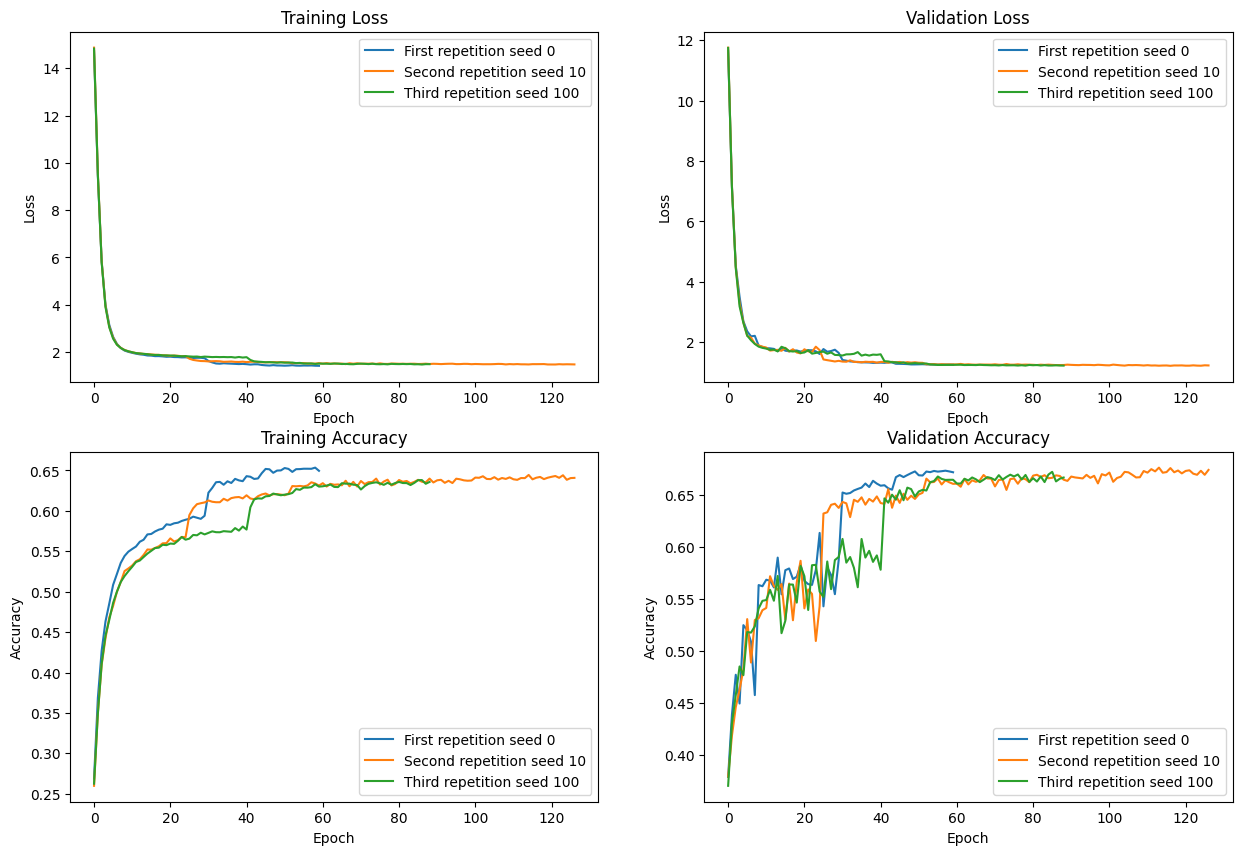

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Training Loss
axs[0, 0].plot(history_1.history['loss'], label='First repetition seed 0')
axs[0, 0].plot(history_11.history['loss'], label='Second repetition seed 10')
axs[0, 0].plot(history_111.history['loss'], label='Third repetition seed 100')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plotting Validation Loss
axs[0, 1].plot(history_1.history['val_loss'], label='First repetition seed 0')
axs[0, 1].plot(history_11.history['val_loss'], label='Second repetition seed 10')
axs[0, 1].plot(history_111.history['val_loss'], label='Third repetition seed 100')
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plotting Training Accuracy
axs[1, 0].plot(history_1.history['accuracy'], label='First repetition seed 0')
axs[1, 0].plot(history_11.history['accuracy'], label='Second repetition seed 10')
axs[1, 0].plot(history_111.history['accuracy'], label='Third repetition seed 100')
axs[1, 0].set_title('Training Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Plotting Validation Accuracy
axs[1, 1].plot(history_1.history['val_accuracy'], label='First repetition seed 0')
axs[1, 1].plot(history_11.history['val_accuracy'], label='Second repetition seed 10')
axs[1, 1].plot(history_111.history['val_accuracy'], label='Third repetition seed 100')
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

Text(0.5, 0.98, 'Aggresivness of augmentations')

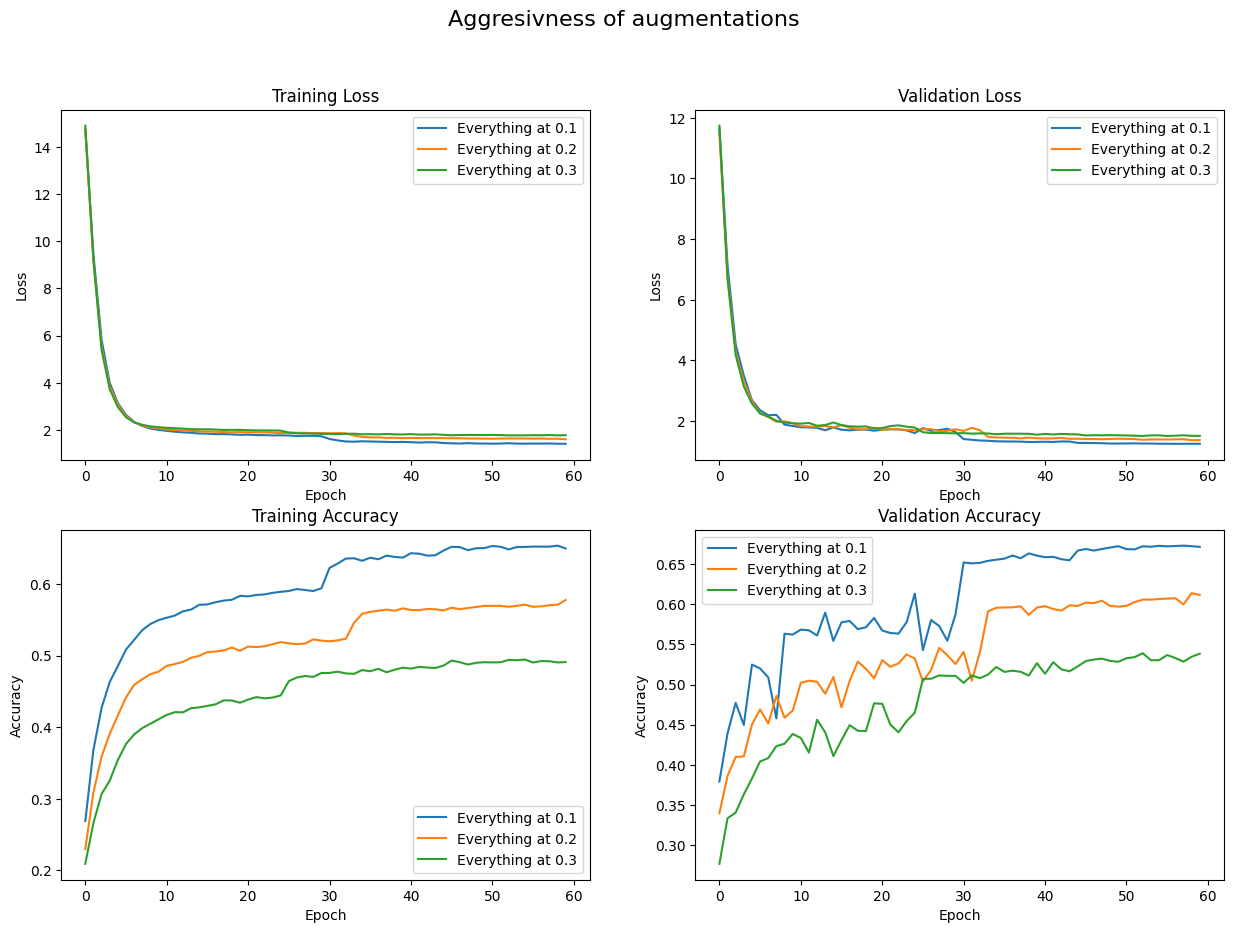

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Training Loss
axs[0, 0].plot(history_1.history['loss'], label='Everything at 0.1')
axs[0, 0].plot(history_2.history['loss'], label='Everything at 0.2')
axs[0, 0].plot(history_3.history['loss'], label='Everything at 0.3')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plotting Validation Loss
axs[0, 1].plot(history_1.history['val_loss'], label='Everything at 0.1')
axs[0, 1].plot(history_2.history['val_loss'], label='Everything at 0.2')
axs[0, 1].plot(history_3.history['val_loss'], label='Everything at 0.3')
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plotting Training Accuracy
axs[1, 0].plot(history_1.history['accuracy'], label='Everything at 0.1')
axs[1, 0].plot(history_2.history['accuracy'], label='Everything at 0.2')
axs[1, 0].plot(history_3.history['accuracy'], label='Everything at 0.3')
axs[1, 0].set_title('Training Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Plotting Validation Accuracy
axs[1, 1].plot(history_1.history['val_accuracy'], label='Everything at 0.1')
axs[1, 1].plot(history_2.history['val_accuracy'], label='Everything at 0.2')
axs[1, 1].plot(history_3.history['val_accuracy'], label='Everything at 0.3')
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

fig.suptitle('Aggresivness of augmentations', fontsize=16)